# Utilisation du model ARIMA :
* Visualisation de la série d'origine. 
* Rendre stationnaire les données.
* Entrainnement de ARIMA

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [4]:
df_interm = pd.read_csv('../dataset/sandp500/all_stocks_5yr.csv')
df_interm.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [5]:
df_interm = df_interm[df_interm['Name'] == 'AAPL']
df_interm['date'] = pd.to_datetime(df_interm['date'], format="%Y/%m/%d")
df = df_interm[['date','close']]
df = df.set_index('date')
df.head()

,close
date,
2013-02-08,67.8542
2013-02-11,68.5614
2013-02-12,66.8428
2013-02-13,66.7156
2013-02-14,66.6556


# Affichons d'abord "close" en fonction de "date"

Text(0,0.5,'Close')

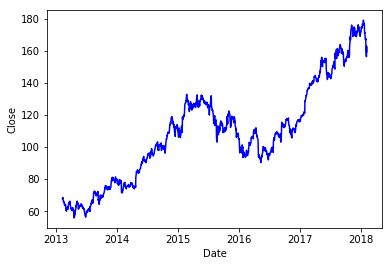

In [6]:
plt.plot(df, color='blue')
plt.xlabel('Date')
plt.ylabel('Close')

En voyons le graphe, on conclut qu'elle n'est pas stationnaire

> Car elle a tendance à augmenter de jour en jour $\implies$ La moyenne n'est pas constante.
> Allons voir la saisonnalité, pour ce faire affichons la Moyenne Mobile pondérée pour 100, 120, 150 jours

In [7]:
def plot_moving_average(window):
    moving_average = df.rolling(window=window).mean()
    plt.plot(df, color='blue', label='Observed data')
    plt.plot(moving_average, color='green', label='Rolling Mean')
    plt.legend(loc='best')
    plt.xlabel('Date')
    plt.ylabel('Close')
    plt.title(str(window)+' days Moving Average')

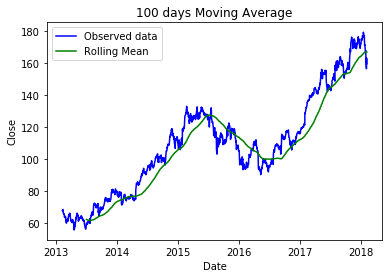

In [8]:
# Moyenne mobile pondérée pour 100 jours

plot_moving_average(100)

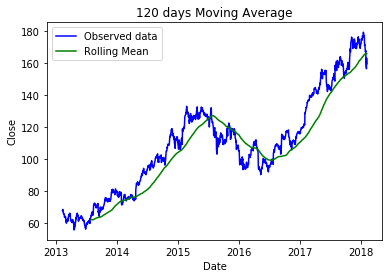

In [9]:
# Moyenne mobile pondérée pour 100 jours

plot_moving_average(120)

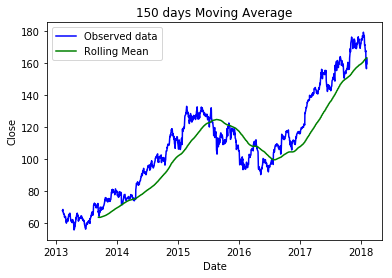

In [10]:
# Moyenne mobile pondérée pour 120 jours

plot_moving_average(150)

> Comme l'on peut observer, la moyenne mobile pondérée pour 150 jours est beaucoup plus lisse que les autres. Prenons 150 comme saisonnalité.

> Allons verifier la stationarity avec l'affichage ainsi que le Dickey Fuller Test. Pour simplifier allons juste faire l'affichage

In [11]:
def verif_stationary(timeseries):
    
    movingAverage = timeseries.rolling(window=150).mean()
    movingSTD = timeseries.rolling(window=150).std()
    
    plt.plot(timeseries, color='blue', label='Observed data')
    plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation\n')
    plt.show(block=False)

# Transformons maintenant les données.

* Rendons à l'echelle logarithmique les données.

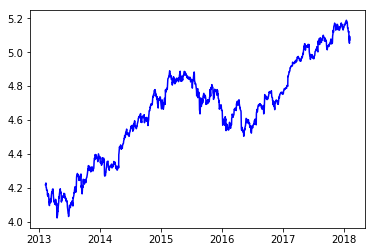

In [12]:
logScale_df = np.log(df)
plt.plot(logScale_df, 'blue')

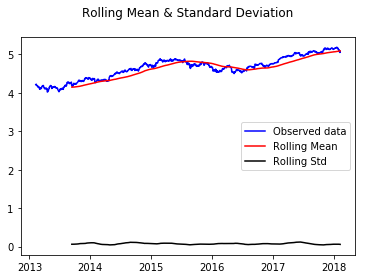

In [13]:
verif_stationary(logScale_df)

> On voit facilement que la moyenne n'est pas constante $\implies$ la série n'est pas stationnaire.

* Transformons les données qui sont à l'echelle logarithmique de façon à les normaliser.

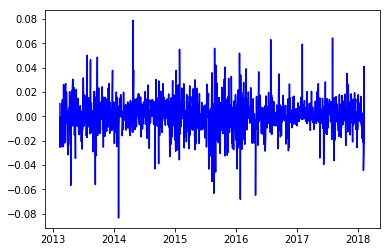

In [14]:
logScale_df_Shifting = logScale_df - logScale_df.shift()
logScale_df_Shifting.dropna(inplace=True)
plt.plot(logScale_df_Shifting, color='blue')

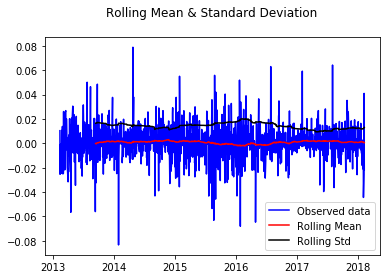

In [15]:
verif_stationary(logScale_df_Shifting)

> On conclut ici que les données sont stationnaires vue que la moyenne est constante.

# Allons entrainner ARIMA

In [16]:
def train_arima(p, d, q):
    model = ARIMA(logScale_df, order=(p,d,q))
    results_ARIMA = model.fit(disp=-1)
    plt.plot(logScale_df_Shifting, color='blue')
    plt.plot(results_ARIMA.fittedvalues, color='green')
    plt.title('ARIMA Trained')
    return results_ARIMA

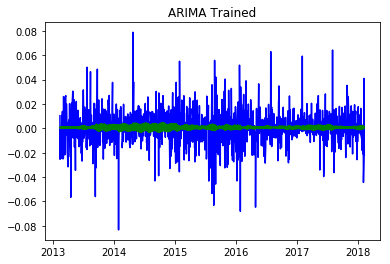

In [17]:
ARIMA_trained = train_arima(2, 1, 2)

In [18]:
predictions = pd.Series(ARIMA_trained.fittedvalues, copy=True)
predictions_cumulated = predictions.cumsum()
predictions_cumulated.head()

date
2013-02-11    0.000678
2013-02-12    0.001437
2013-02-13    0.001761
2013-02-14    0.002815
2013-02-15    0.003501
dtype: float64

In [19]:
# faisons la prédiction à l'etat logarithmique
predictions_log_scale = pd.Series(logScale_df['close'].iloc[0], index=logScale_df.index)
predictions_log_scale = predictions_log_scale.add(predictions_cumulated, fill_value=0)
predictions_log_scale.head()

date
2013-02-08    4.217361
2013-02-11    4.218039
2013-02-12    4.218798
2013-02-13    4.219122
2013-02-14    4.220176
dtype: float64

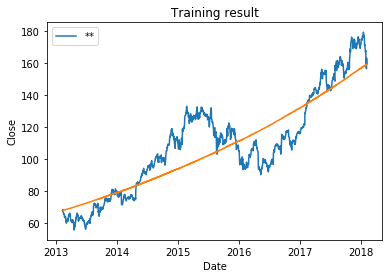

In [21]:
# retournons à l'etat initiale les données
predictions_ARIMA = np.exp(predictions_log_scale)
plt.plot(df, label='Observé')
plt.plot(predictions_ARIMA, label='Observé')
plt.title('Training result')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()

> On en déduit que ARIMA n'arrive pas à bien généraliser les données.

**Référence : ** Python for Finance Cookbook